### Predict Forclosure Probability
#### Problem Statement

    India is a diversified financial sector undergoing rapid expansion, both in terms of strong growth of existing financial services firms and new entities entering the market. The sector comprises commercial banks, insurance companies, non-banking financial companies, co-operatives, pension funds, mutual funds and other smaller financial entities .
    The Edelweiss Group is one of India&#39;s leading diversified financial services company providing a broad range of financial products and services to a substantial and diversified client base that includes corporations, institutions and individuals. Edelweiss&#39;s products and services span multiple asset classes and consumer segments across domestic and global geographies.
    Given the availability of various alternatives across the industry customer has a propensity to move to another financial institution for Balance Transfer. Foreclosure and balance transfer has added to the concerns of NBFCs. Foreclosure means repaying the outstanding loan amount in a single payment instead of with EMIs while balance transfer is transferring outstanding Loan availed from one Bank / Financial Institution to another Bank / Financial Institution, usually on the grounds of better service, top-up on the existing loan, proximity of branch, saving on interest repayments, etc. Losing out on customers on grounds on foreclosure and balance transfer leads to revenue loss. Acquiring a new customer can cost up to five times more than retaining an existing customer and an increase in customer retention by 5% increases profits up to 25%.
    NBFCs have started taking pro-active measures to ensure this is curbed; and this is where you come in! Objective is primarily to arrive at a propensity to foreclose and balance transfer an existing loan based on lead indicators such as demographics, internal behavior and performance on all credit lines; along with the estimated ‘Time to Foreclose’. May the best algorithm win!

    Participants are free to use any openly available data source to further enrich the dataset.
#### Data Description

    We have provided the following dataset:

    Customer demographics

    Customer transactions (ie. repayments made by the client)

    List of foreclosed customers 

    Email interaction of the customer with the customer representative

    The participants are expected to predict the probability of foreclosure for each of the data points in the test set.


#### Evaluation Metrics

    The submissions will be evaluated on Area Under the ROC curve (AUCROC) metrics.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from collections import Counter

In [3]:
%matplotlib inline

In [6]:
plt.style.use('ggplot')
sns.set(style= 'white', color_codes= True, palette= 'muted')

pd.options.display.max_columns= 200
pd.options.display.max_rows= 500

In [9]:
#Now Read the data
train= pd.read_csv('train_foreclosure.csv')
test= pd.read_csv('test_foreclosure.csv')

In [10]:
cust_demo= pd.read_excel('Customers_31JAN2019.xlsx')

In [199]:
lms= pd.read_csv('LMS_31JAN20191.csv')

In [14]:
rf_final= pd.read_excel('RF_Final_Data.xlsx')

In [16]:
#Now check out the shape and size of the datasets
train.shape, test.shape, cust_demo.shape, lms.shape, rf_final.shape

((20012, 2), (13342, 2), (10000, 15), (624250, 38), (7511, 9))

In [18]:
train.head()

,AGREEMENTID,FORECLOSURE
0,11220001,1
1,11220002,1
2,11220006,1
3,11220008,1
4,11220010,1


In [19]:
test.head()

,AGREEMENTID,FORECLOSURE
0,11220003,NaN
1,11220004,NaN
2,11220005,NaN
3,11220007,NaN
4,11220009,NaN


In [20]:
cust_demo.head()

,CUSTOMERID,CUST_CONSTTYPE_ID,CUST_CATEGORYID,PROFESSION,AGE,SEX,MARITAL_STATUS,QUALIFICATION,NO_OF_DEPENDENT,OCCUPATION,POSITION,GROSS_INCOME,PRE_JOBYEARS,NETTAKEHOMEINCOME,BRANCH_PINCODE
0,12001000,1,5,NaN,33.0,M,M,POSTGRAD,0.0,NaN,NaN,198375.221829,8.0,198375.221829,400070.0
1,12001001,1,5,NaN,44.0,M,M,POSTGRAD,0.0,NaN,NaN,242703.982915,10.0,242703.982915,400070.0
2,12001002,1,7,NaN,50.0,M,M,GRAD,0.0,NaN,NaN,0.000000,NaN,0.000000,400070.0
3,12001003,3,4,NaN,40.0,M,M,GRAD,0.0,NaN,NaN,365263.511624,NaN,365263.516128,400070.0
4,12001004,3,4,NaN,27.0,M,M,GRAD,0.0,NaN,NaN,187342.198995,NaN,187342.198995,400070.0


In [21]:
lms.head()

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,12001000.0,"11,710,107.24","11,710,107.24",30-Aug-10,13.7,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7.516699e+06,7.332154e+06,184544.3966,29042.45880,29042.4588,0.00000,184544.39660,2.262177e+06,9.447930e+06,2617476.019,9.338009e+06,1-Nov-13,83559.0,40.06,39,19.0,0.0,0.6000,HL,10901100.0,NaN,NaN,39
1,11220002,12001001.0,"19,290,253.32","19,290,253.32",15-Sep-10,13.7,10.6,137.0,180,1,15-Sep-10,MUMBAI,100504.575900,100504.575900,0.0,1.061903e+07,1.033958e+07,279448.0846,0.00000,0.0000,0.00000,279448.08460,1.234760e+07,6.942656e+06,4945153.591,1.713861e+07,1-Nov-13,126530.0,84.31,38,99.0,0.0,0.6000,HL,10901100.0,NaN,NaN,38
2,11220003,12001002.0,"4,053,498.66","4,053,498.66",6-Sep-10,17.2,12.5,360.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,2.439242e+06,2.439242e+06,0.0000,0.44171,0.0000,0.44171,-0.44171,3.944954e+06,1.085444e+05,1549566.273,3.944954e+06,5-Nov-13,30898.0,79.34,38,322.0,0.0,0.9100,HL,10901101.0,NaN,NaN,38
3,11220004,12001003.0,"13,257,031.92","13,257,031.92",29-Sep-10,15.6,10.9,198.0,180,5,29-Sep-10,MUMBAI,28441.732660,28441.732660,0.0,7.211965e+06,7.211965e+06,0.0000,0.00000,0.0000,0.00000,0.00000,1.030278e+07,2.954253e+06,4219463.668,1.255472e+07,5-Nov-13,88256.0,86.86,37,161.0,0.0,0.9686,HL,10901101.0,NaN,NaN,38
4,11220005,12001004.0,"13,211,403.04","13,211,403.04",6-Sep-10,16.5,11.9,142.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,7.712034e+06,7.712034e+06,0.0000,0.00000,0.0000,0.00000,0.00000,8.479158e+06,4.732245e+06,3812974.258,1.178201e+07,5-Nov-13,91892.0,40.93,38,104.0,0.0,0.7300,HL,10901101.0,NaN,NaN,38


In [22]:
rf_final.head()

,TicketId,Type,SubType,Status,Date,Preprocessed_EmailBody,Preprocessed_Subject,Masked_CustomerID,Masked_AgreementID
0,571910,REQUEST,PROVISIONAL IT CERTIFICATE,Close,2019-01-23 16:34:00,"hi team, can you please provide me itcertifica...",loan account number - loannumber,12020736,0
1,572747,REQUEST,SOA,Close,2019-01-24 16:05:00,hi team can you please arrange the certificate...,certificate of interest and principal for home...,12019080,0
2,4622,General,Others,Close,2016-02-12 13:40:00,NaN,re: repaysch : loan number loannumber,12004815,0
3,4674,REQUEST,SOA,Close,2016-02-12 15:41:00,"dear sir, you for your promptreply, please not...",re: finalit : loan number loannumber,12005158,11230237
4,4681,QUERY,CHANGEOFROI,Close,2016-02-12 15:55:00,"dear sachin, for your mail. this seems a great...",re: fw: repaysch : loan number loannumber,12001022,0


In [23]:
for col in lms:
    print(col, len(lms[col].unique())) #get the number of unique element of each columns

AGREEMENTID 33354
CUSTOMERID 32896
LOAN_AMT 13667
NET_DISBURSED_AMT 17774
INTEREST_START_DATE 1847
CURRENT_ROI 132
ORIGNAL_ROI 104
CURRENT_TENOR 450
ORIGNAL_TENOR 94
DUEDAY 3
AUTHORIZATIONDATE 2481
CITY 317
PRE_EMI_DUEAMT 28022
PRE_EMI_RECEIVED_AMT 27763
PRE_EMI_OS_AMOUNT 914
EMI_DUEAMT 314986
EMI_RECEIVED_AMT 313468
EMI_OS_AMOUNT 24472
EXCESS_AVAILABLE 18174
EXCESS_ADJUSTED_AMT 9257
BALANCE_EXCESS 10733
NET_RECEIVABLE 37792
OUTSTANDING_PRINCIPAL 437898
PAID_PRINCIPAL 243571
PAID_INTEREST 390829
MONTHOPENING 436869
LAST_RECEIPT_DATE 1665
LAST_RECEIPT_AMOUNT 45061
NET_LTV 8110
COMPLETED_TENURE 99
BALANCE_TENURE 542
DPD 453
FOIR 495
PRODUCT 4
SCHEMEID 251
NPA_IN_LAST_MONTH 6
NPA_IN_CURRENT_MONTH 4
MOB 99


In [24]:
lms.dtypes

AGREEMENTID                int64
CUSTOMERID               float64
LOAN_AMT                  object
NET_DISBURSED_AMT         object
INTEREST_START_DATE       object
CURRENT_ROI              float64
ORIGNAL_ROI              float64
CURRENT_TENOR            float64
ORIGNAL_TENOR              int64
DUEDAY                     int64
AUTHORIZATIONDATE         object
CITY                      object
PRE_EMI_DUEAMT           float64
PRE_EMI_RECEIVED_AMT     float64
PRE_EMI_OS_AMOUNT        float64
EMI_DUEAMT               float64
EMI_RECEIVED_AMT         float64
EMI_OS_AMOUNT            float64
EXCESS_AVAILABLE         float64
EXCESS_ADJUSTED_AMT      float64
BALANCE_EXCESS           float64
NET_RECEIVABLE           float64
OUTSTANDING_PRINCIPAL    float64
PAID_PRINCIPAL           float64
PAID_INTEREST            float64
MONTHOPENING             float64
LAST_RECEIPT_DATE         object
LAST_RECEIPT_AMOUNT      float64
NET_LTV                  float64
COMPLETED_TENURE           int64
BALANCE_TE

In [200]:
lms['LOAN_AMT']= lms['LOAN_AMT'].apply(lambda x: float(x.replace(',', '')))

In [201]:
lms['NET_DISBURSED_AMT']= lms['NET_DISBURSED_AMT'].apply(lambda x: float(x.replace(',', '')))

In [202]:
lms['INTEREST_START_DATE']= pd.to_datetime(lms['INTEREST_START_DATE'], dayfirst= True)
lms['LAST_RECEIPT_DATE']= pd.to_datetime(lms['LAST_RECEIPT_DATE'], dayfirst= True)

In [203]:
lms['CUSTOMERID']= lms['CUSTOMERID'].apply(lambda x: str(str(x).split('.')[0]))

In [31]:
lms.head()

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.7,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7.516699e+06,7.332154e+06,184544.3966,29042.45880,29042.4588,0.00000,184544.39660,2.262177e+06,9.447930e+06,2617476.019,9.338009e+06,2013-11-01,83559.0,40.06,39,19.0,0.0,0.6000,HL,10901100.0,NaN,NaN,39
1,11220002,12001001,19290253.32,19290253.32,2010-09-15,13.7,10.6,137.0,180,1,15-Sep-10,MUMBAI,100504.575900,100504.575900,0.0,1.061903e+07,1.033958e+07,279448.0846,0.00000,0.0000,0.00000,279448.08460,1.234760e+07,6.942656e+06,4945153.591,1.713861e+07,2013-11-01,126530.0,84.31,38,99.0,0.0,0.6000,HL,10901100.0,NaN,NaN,38
2,11220003,12001002,4053498.66,4053498.66,2010-09-06,17.2,12.5,360.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,2.439242e+06,2.439242e+06,0.0000,0.44171,0.0000,0.44171,-0.44171,3.944954e+06,1.085444e+05,1549566.273,3.944954e+06,2013-11-05,30898.0,79.34,38,322.0,0.0,0.9100,HL,10901101.0,NaN,NaN,38
3,11220004,12001003,13257031.92,13257031.92,2010-09-29,15.6,10.9,198.0,180,5,29-Sep-10,MUMBAI,28441.732660,28441.732660,0.0,7.211965e+06,7.211965e+06,0.0000,0.00000,0.0000,0.00000,0.00000,1.030278e+07,2.954253e+06,4219463.668,1.255472e+07,2013-11-05,88256.0,86.86,37,161.0,0.0,0.9686,HL,10901101.0,NaN,NaN,38
4,11220005,12001004,13211403.04,13211403.04,2010-09-06,16.5,11.9,142.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,7.712034e+06,7.712034e+06,0.0000,0.00000,0.0000,0.00000,0.00000,8.479158e+06,4.732245e+06,3812974.258,1.178201e+07,2013-11-05,91892.0,40.93,38,104.0,0.0,0.7300,HL,10901101.0,NaN,NaN,38


In [32]:
#The description of the lms file
lms.describe()

,AGREEMENTID,LOAN_AMT,NET_DISBURSED_AMT,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,SCHEMEID,MOB
count,6.242500e+05,6.242500e+05,6.242500e+05,624250.000000,624250.000000,624245.000000,624250.000000,624250.000000,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.242500e+05,6.122050e+05,624250.000000,624250.000000,624245.000000,624219.000000,624250.000000,6.237340e+05,624250.000000
mean,1.123081e+07,5.828204e+06,5.778192e+06,15.070269,14.994811,178.406491,177.910326,6.405117,6.221159e+04,6.201999e+04,1.915964e+02,1.868918e+06,1.832613e+06,3.630521e+04,2.176622e+05,2.088516e+05,8.810573e+03,2.768623e+04,5.303931e+06,5.320235e+05,9.637954e+05,5.442760e+06,4.855566e+04,48.825046,15.256937,163.149432,7.921803,21.479576,1.090119e+07,16.767239
std,7.984211e+03,1.323121e+07,1.313555e+07,2.516013,2.481546,49.490712,44.212338,3.533971,3.555793e+05,3.549530e+05,9.510358e+03,6.891111e+06,6.782725e+06,5.739616e+05,2.274487e+06,2.234830e+06,4.076866e+05,6.818236e+05,1.209923e+07,1.235317e+07,3.293273e+06,1.226295e+07,2.398423e+05,20.531984,15.549111,52.995329,65.112792,2687.131947,8.546587e+01,15.613276
min,1.122000e+07,3.753240e+04,3.753240e+04,-5.100000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.734998e+07,-7.506479e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,0.380000,0.000000,0.000000,0.000000,-170.330000,1.090110e+07,0.000000
25%,1.122430e+07,1.516309e+06,1.501296e+06,13.100000,13.100000,150.000000,168.000000,5.000000,4.975868e+03,4.967033e+03,0.000000e+00,1.233145e+05,1.215195e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.104276e+00,1.441153e+06,1.406301e+04,8.360153e+04,1.469379e+06,1.040000e+04,32.780000,3.000000,128.000000,0.000000,0.400000,1.090111e+07,5.000000
50%,1.122894e+07,2.627268e+06,2.593211e+06,15.000000,15.000000,180.000000,180.000000,5.000000,1.222875e+04,1.221992e+04,0.000000e+00,4.614637e+05,4.531783e+05,0.000000e+00,1.104276e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.404174e+06,5.964873e+04,2.681067e+05,2.483012e+06,1.900000e+04,50.290000,10.000000,169.000000,0.000000,0.510000,1.090115e+07,12.000000
75%,1.123592e+07,5.209731e+06,5.166899e+06,17.200000,16.500000,203.000000,180.000000,5.000000,3.607449e+04,3.607449e+04,0.000000e+00,1.403642e+06,1.371928e+06,0.000000e+00,1.329548e+03,2.606091e+02,1.104276e+00,0.000000e+00,4.654986e+06,2.129521e+05,7.640072e+05,4.850362e+06,3.759200e+04,64.840000,23.000000,182.000000,0.000000,0.690000,1.090129e+07,24.000000
max,1.125335e+07,5.704924e+08,5.674589e+08,37.500000,34.100000,713.000000,300.000000,15.000000,3.177540e+07,3.177540e+07,2.089129e+06,3.936390e+08,3.888015e+08,5.899531e+07,2.841642e+08,2.841642e+08,7.734998e+07,5.672502e+07,5.674589e+08,4.885217e+09,1.845529e+08,5.674589e+08,8.496881e+07,104.860000,98.000000,693.000000,2268.000000,547616.000000,1.090146e+07,98.000000


In [33]:
#Now check out the null values present in the dataset or not
def check_null_values(df):
    if df.isnull().sum().any():
        null_values= df.isnull().sum()
        null_percent= (null_values/df.shape[0])*100
        
        #creating the dataframe that containing the number of null values, percentage and datatypes
        df_null= pd.DataFrame()
        df_null['null_values']= null_values
        df_null['null_pct']= null_percent
        df_null['dtypes']= df.dtypes
        df_null= df_null.sort_values(by= 'null_pct', ascending= False)
        return df_null
    
    else:
        return False #if dataset not containig any null values

In [36]:
check_null_values(lms).head(10)

,null_values,null_pct,dtypes
NPA_IN_LAST_MONTH,610891,97.859992,object
NPA_IN_CURRENT_MONTH,610814,97.847657,object
LAST_RECEIPT_AMOUNT,12045,1.929515,float64
LAST_RECEIPT_DATE,3787,0.606648,datetime64[ns]
SCHEMEID,516,0.082659,float64
DPD,31,0.004966,float64
CITY,8,0.001282,object
CURRENT_TENOR,5,0.000801,float64
BALANCE_TENURE,5,0.000801,float64
AGREEMENTID,0,0.000000,int64


In [37]:
check_null_values(rf_final)

,null_values,null_pct,dtypes
Preprocessed_Subject,183,2.436427,object
Preprocessed_EmailBody,155,2.063640,object
TicketId,0,0.000000,int64
Type,0,0.000000,object
SubType,0,0.000000,object
Status,0,0.000000,object
Date,0,0.000000,object
Masked_CustomerID,0,0.000000,int64
Masked_AgreementID,0,0.000000,int64


In [38]:
check_null_values(cust_demo)

,null_values,null_pct,dtypes
PROFESSION,10000,100.00,float64
OCCUPATION,10000,100.00,float64
POSITION,9339,93.39,object
PRE_JOBYEARS,7625,76.25,float64
QUALIFICATION,603,6.03,object
AGE,396,3.96,float64
MARITAL_STATUS,396,3.96,object
SEX,394,3.94,object
NO_OF_DEPENDENT,79,0.79,float64
BRANCH_PINCODE,73,0.73,float64


### LMS DATA

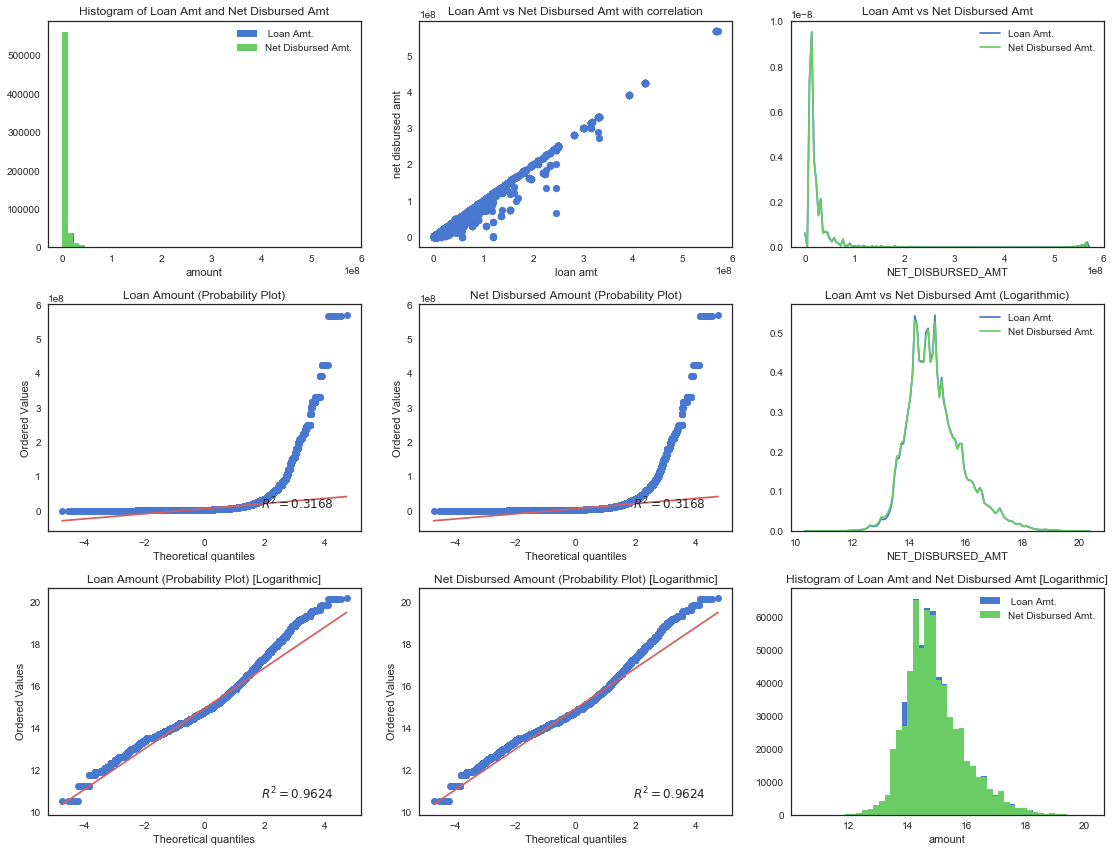

In [46]:
#Let's check the relation between the loan amount and net disbursed amount
plt.figure(figsize= (16, 12))
plt.subplot(331)
plt.hist(lms['LOAN_AMT'], bins= 50, label= ' Loan Amt.')
plt.hist(lms['NET_DISBURSED_AMT'], bins= 50, label= 'Net Disbursed Amt.')
plt.xlabel('amount')
plt.title('Histogram of Loan Amt and Net Disbursed Amt')
plt.legend(loc= 1)

plt.subplot(332)
plt.scatter(lms['LOAN_AMT'], lms['NET_DISBURSED_AMT'])
plt.xlabel('loan amt')
plt.ylabel('net disbursed amt')
plt.title('Loan Amt vs Net Disbursed Amt with correlation')

plt.subplot(333)
sns.distplot(lms['LOAN_AMT'], hist= False, bins= 50, label= 'Loan Amt.')
sns.distplot(lms['NET_DISBURSED_AMT'], hist= False, bins= 50, label= 'Net Disbursed Amt.')
plt.title('Loan Amt vs Net Disbursed Amt')
plt.legend(loc= 1)

plt.subplot(334)
st.probplot(lms['LOAN_AMT'], plot= plt, rvalue= True)
plt.title('Loan Amount (Probability Plot)')

plt.subplot(335)
st.probplot(lms['LOAN_AMT'], plot= plt, rvalue= True)
plt.title('Net Disbursed Amount (Probability Plot)')

plt.subplot(336)
sns.distplot(np.log(lms['LOAN_AMT']), hist= False, bins= 50, label= 'Loan Amt.')
sns.distplot(np.log(lms['NET_DISBURSED_AMT']), hist= False, bins= 50, label= 'Net Disbursed Amt.')
plt.title('Loan Amt vs Net Disbursed Amt (Logarithmic)')
plt.legend(loc= 1)

plt.subplot(337)
st.probplot(np.log(lms['LOAN_AMT']), plot= plt, rvalue= True)
plt.title('Loan Amount (Probability Plot) [Logarithmic]')

plt.subplot(338)
st.probplot(np.log(lms['LOAN_AMT']), plot= plt, rvalue= True)
plt.title('Net Disbursed Amount (Probability Plot) [Logarithmic]')

plt.subplot(339)
plt.hist(np.log(lms['LOAN_AMT']), bins= 50, label= ' Loan Amt.')
plt.hist(np.log(lms['NET_DISBURSED_AMT']), bins= 50, label= 'Net Disbursed Amt.')
plt.xlabel('amount')
plt.title('Histogram of Loan Amt and Net Disbursed Amt [Logarithmic]')
plt.legend(loc= 1)

plt.tight_layout()
plt.show()

In [45]:
#from the graph it clear that I've to transfrom the Amount in logarithmic form

In [204]:
lms['AGREEMENTID']= lms['AGREEMENTID'].astype(str)

In [52]:
len(cust_demo['CUSTOMERID'].unique())

10000

In [53]:
len(lms['CUSTOMERID'].unique())

32896

In [55]:
len(rf_final['Masked_CustomerID'].unique())

2709

In [56]:
set(cust_demo['CUSTOMERID']).issubset(set(lms['CUSTOMERID']))

False

In [60]:
set(train['AGREEMENTID']).issubset(set(lms['AGREEMENTID']))

False

In [61]:
train.head()

,AGREEMENTID,FORECLOSURE
0,11220001,1
1,11220002,1
2,11220006,1
3,11220008,1
4,11220010,1


In [62]:
lms[lms['AGREEMENTID']== '11220001']

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.7,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7516698.513,7332154.116,184544.3966,29042.4588,29042.4588,0.0,184544.3966,2.262177e+06,9.447930e+06,2617476.019,9338009.117,2013-11-01,83559.0,40.06,39,19.0,0.0,0.6,HL,10901100.0,NaN,NaN,39
2855,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.7,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7701242.910,7516698.513,184544.3966,29042.4588,29042.4588,0.0,184544.3966,2.157467e+06,9.552641e+06,2638212.637,9233298.960,2013-12-01,83559.0,40.06,40,18.0,0.0,0.6,HL,10901100.0,NaN,NaN,40
5825,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.4,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7885787.306,7701242.910,184544.3966,29042.4588,29042.4588,0.0,184544.3966,2.051797e+06,9.658311e+06,2657989.417,9127628.964,2014-01-01,83559.0,40.06,41,17.0,0.0,0.6,HL,10901100.0,NaN,NaN,41
8928,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.4,10.6,58.0,120,1,30-Aug-70,MUMBAI,7994.273589,7994.273589,0.0,7885787.306,7885787.306,0.0000,29042.4588,29042.4588,0.0,0.0000,1.944731e+06,9.765377e+06,2676370.096,9020562.868,1974-02-02,83559.0,40.06,41,17.0,0.0,0.6,HL,10901100.0,NaN,NaN,42
12193,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.4,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,8254876.099,8070331.703,184544.3966,213586.8554,213586.8554,0.0,184544.3966,1.836705e+06,9.873402e+06,2693791.643,8912537.639,2014-03-01,83559.0,40.06,43,15.0,0.0,0.6,HL,10901100.0,NaN,NaN,43
15534,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.4,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,8439420.496,8254876.099,184544.3966,213586.8554,213586.8554,0.0,184544.3966,1.727712e+06,9.982395e+06,2710245.455,8803544.675,2014-04-01,83559.0,40.06,44,14.0,0.0,0.6,HL,10901100.0,NaN,NaN,44
18931,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.4,10.6,45.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,8614898.278,8439420.496,175477.7826,213586.8554,213586.8554,0.0,175477.7826,1.164472e+05,1.159366e+07,2725722.884,8693575.328,2014-05-05,1000000.0,40.06,45,0.0,0.0,0.6,HL,10901100.0,NaN,NaN,45


In [205]:
lms.drop(['NPA_IN_LAST_MONTH', 'NPA_IN_CURRENT_MONTH'], axis= 1, inplace= True)

In [65]:
lms_group_by= lms.groupby('AGREEMENTID').mean().reset_index()

In [206]:
train['AGREEMENTID']= train['AGREEMENTID'].astype(str)

In [73]:
train_1= pd.merge(train, lms_group_by, on= 'AGREEMENTID')

In [74]:
train.shape, train_1.shape

((20012, 2), (20012, 31))

In [76]:
train_1.head()

,AGREEMENTID,FORECLOSURE,LOAN_AMT,NET_DISBURSED_AMT,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,SCHEMEID,MOB
0,11220001,1,11710107.24,11710107.24,13.485714,10.6,56.142857,120.0,1.0,7994.273589,7994.273589,0.0,8.042673e+06,7.885787e+06,156885.680800,1.081329e+05,1.081329e+05,0.0,156885.680800,1.728148e+06,9.981959e+06,2.674258e+06,9.018451e+06,214479.142857,40.06,41.857143,14.285714,0.0,0.60,10901100.0,42.0
1,11220002,1,19290253.32,19290253.32,13.700000,10.6,137.000000,180.0,1.0,100504.575900,100504.575900,0.0,1.061903e+07,1.033958e+07,279448.084600,0.000000e+00,0.000000e+00,0.0,279448.084600,1.234760e+07,6.942656e+06,4.945154e+06,1.713861e+07,126530.000000,84.31,38.000000,99.000000,0.0,0.60,10901100.0,38.0
2,11220006,1,3933395.00,3933395.00,16.023913,11.5,339.108696,180.0,5.0,5947.630536,5947.630536,0.0,3.476482e+06,3.476482e+06,0.000000,7.124384e+05,7.124384e+05,0.0,0.000000,3.352789e+06,5.806061e+05,2.227225e+06,3.793387e+06,35825.000000,50.89,58.500000,280.608696,0.0,0.72,10901101.0,58.5
3,11220008,1,10022587.71,10022587.71,12.783636,10.6,113.709091,180.0,1.0,60322.180780,60322.180780,0.0,9.288192e+06,9.147122e+06,141070.134214,5.053681e+06,5.053681e+06,0.0,141070.134214,3.386821e+06,6.635767e+06,4.167961e+06,7.931653e+06,116700.581818,84.63,63.981818,49.727273,0.0,0.60,10901100.0,64.0
4,11220010,1,7755937.31,7755937.31,15.361111,10.9,324.851852,180.0,5.0,27732.787460,27732.787460,0.0,7.303453e+06,7.303453e+06,0.000000,1.113131e+05,1.113131e+05,0.0,0.000000,7.386386e+06,3.695513e+05,4.613930e+06,7.386386e+06,54433.000000,30.94,62.500000,262.351852,0.0,0.83,10901101.0,63.5


In [77]:
test['AGREEMENTID']= test['AGREEMENTID'].astype(str)

In [81]:
test_1= pd.merge(test, lms_group_by, on= 'AGREEMENTID')

In [82]:
test.shape, test_1.shape

((13342, 2), (13342, 31))

In [85]:
target= train_1['FORECLOSURE']

In [86]:
train_1.drop(['FORECLOSURE'], axis= 1, inplace= True)
test_1.drop(['FORECLOSURE'], axis= 1, inplace= True)

In [88]:
train_1.fillna(-999, inplace= True)
test_1.fillna(-999, inplace= True)

In [89]:
Counter(target)

Counter({0: 18217, 1: 1795})

In [98]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def run_XGB(train, target, test):
    
    param_xgb= {}
    param_xgb['eda']= 0.01
    param_xgb['max_depth']= 3
    param_xgb['objective']= 'binary:logistic'
    param_xgb['eval_metric']= 'auc'
    param_xgb['seed']= 2018
    
    #split the data in trainig and validating form
    X_train, X_test, y_train, y_test= train_test_split(train, target, test_size= 0.2, random_state= 2018)
    #prepare data for the training
    dtrain= xgb.DMatrix(X_train, y_train)
    dtest= xgb.DMatrix(X_test, y_test)
    dtest_1= xgb.DMatrix(test)
    
    watchlist= [(dtrain, 'train'), (dtest, 'eval')]
    
    model= xgb.train(param_xgb, dtrain, num_boost_round= 1000, evals= watchlist, verbose_eval= 100)#, early_stopping_rounds= 50)
    
    #do prediction
    prediction= model.predict(dtest)
    prediction_1= prediction.copy()

    prediction_2= model.predict(dtest_1)
    
    for i in range(len(prediction)):
        if prediction[i]<0.5:
            prediction[i]= 0
        else:
            prediction[i]= 1
            
    
    #accuracy
    print('Testing accuracy: {:.4f}' .format(accuracy_score(y_test, prediction)))
    print('f1 score: {}' .format(f1_score(y_test, prediction)))
    print('ROC AUC: {}' .format(roc_auc_score(y_test, prediction)))
    
    print('Confusion Matrix: ')
    cm= confusion_matrix(y_test, prediction)
    print(cm)
    print('Classification Report: ')
    print(classification_report(y_test, prediction))
    
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('True Positive Rate: {}' .format(TPR))
    print('True Negative Rate: {}' .format(TNR))
    print('False Positive Rate: {}' .format(FPR))
    print('False Negative Rate: {}' .format(FNR))
    print('Overall Accuracy: {}' .format(ACC))
    
    #plot the feature Importance
    xgb.plot_importance(model)
    plt.show()

    return prediction_2

[0]	train-auc:0.643788	eval-auc:0.63162
[100]	train-auc:0.80345	eval-auc:0.789964
[200]	train-auc:0.803496	eval-auc:0.789891
[300]	train-auc:0.803496	eval-auc:0.789891
[400]	train-auc:0.803496	eval-auc:0.789891
[500]	train-auc:0.803496	eval-auc:0.789891
[600]	train-auc:0.803496	eval-auc:0.789891
[700]	train-auc:0.803496	eval-auc:0.789891
[800]	train-auc:0.803496	eval-auc:0.789891
[900]	train-auc:0.803496	eval-auc:0.789891
[999]	train-auc:0.803496	eval-auc:0.789891
Testing accuracy: 0.9098
f1 score: 0.026954177897574125
ROC AUC: 0.5068306010928961
Confusion Matrix: 
[[3637    0]
 [ 361    5]]
Classification Report: 
             precision    recall  f1-score   support

          0       0.91      1.00      0.95      3637
          1       1.00      0.01      0.03       366

avg / total       0.92      0.91      0.87      4003

True Positive Rate: 0.9097048524262131
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.0902951475737869
Overall Accuracy: 0.90981763677242

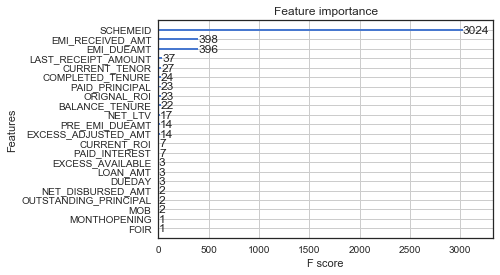

In [99]:
pred_xgb_1= run_XGB(train_1.drop(['AGREEMENTID'], axis= 1), target, test_1.drop(['AGREEMENTID'], axis= 1))

In [100]:
test['FORECLOSURE']= pred_xgb_1

In [101]:
test.head()

,AGREEMENTID,FORECLOSURE
0,11220003,0.011363
1,11220004,0.716523
2,11220005,0.897905
3,11220007,0.028522
4,11220009,0.189453


In [102]:
test.to_csv('sample_1.csv', index= False)

In [117]:
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score #consider only three metrics because the accuracy is not
#only metrics to determine the performance of the classification problems

#from processing import preprocessing_data

def run_CB(train, target, test):
    
    X_train, X_test, y_train, y_test= train_test_split(train, target, test_size= 0.20, random_state= 2018)
    
    param_cb= {}
    param_cb['iterations']= 10001
    param_cb['learning_rate']= 0.01
    param_cb['max_depth']= 3
    param_cb['logging_level']= 'Silent'
    param_cb['random_seed']= 2018
    param_cb['eval_metric']= 'AUC'
    #param_cb['one_hot_max_size']= 5
    model= cb.CatBoostClassifier(**param_cb)

    #fit the data into the model
    model.fit(X_train, y_train, eval_set= (X_test, y_test), early_stopping_rounds= 50, verbose= 100)
    prediction= model.predict(X_test)
    prediction_1= model.predict_proba(X_test)[::,1]
    
    prediction_2= model.predict_proba(test)

    #accuracy
    print('Training accuracy: {:.4f}' .format(model.score(X_train, y_train)))
    print('Testing accuracy: {:.4f}' .format(accuracy_score(y_test, prediction)))
    print('f1 score: {}' .format(f1_score(y_test, prediction)))
    print('ROC AUC: {}' .format(roc_auc_score(y_test, prediction)))
    
    cm= confusion_matrix(y_test, prediction)
    
    print('Confusion Matrix: ')
    print(cm)
    print('Classification Report: ')
    print(classification_report(y_test, prediction))
    
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('True Positive Rate: {}' .format(TPR))
    print('True Negative Rate: {}' .format(TNR))
    print('False Positive Rate: {}' .format(FPR))
    print('False Negative Rate: {}' .format(FNR))
    print('Overall Accuracy: {}' .format(ACC))
    
    return prediction_2

In [105]:
pred_cb_1= run_CB(train_1.drop(['AGREEMENTID'], axis= 1), target, test_1.drop(['AGREEMENTID'], axis= 1))

0:	learn: 0.6809831	test: 0.6810029	best: 0.6810029 (0)	total: 213ms	remaining: 6m 2s
100:	learn: 0.2627469	test: 0.2652156	best: 0.2652156 (100)	total: 4.15s	remaining: 1m 5s
200:	learn: 0.2104175	test: 0.2157614	best: 0.2157614 (200)	total: 8.03s	remaining: 59.9s
300:	learn: 0.1927944	test: 0.1988686	best: 0.1988686 (300)	total: 11.6s	remaining: 54s
400:	learn: 0.1829109	test: 0.1892837	best: 0.1892837 (400)	total: 14.8s	remaining: 48.1s
500:	learn: 0.1749659	test: 0.1816100	best: 0.1816100 (500)	total: 18.5s	remaining: 44.3s
600:	learn: 0.1694398	test: 0.1764066	best: 0.1764066 (600)	total: 22.5s	remaining: 41.1s
700:	learn: 0.1638986	test: 0.1710229	best: 0.1710229 (700)	total: 26.2s	remaining: 37.3s
800:	learn: 0.1598800	test: 0.1672050	best: 0.1672050 (800)	total: 29.4s	remaining: 33.1s
900:	learn: 0.1561440	test: 0.1639501	best: 0.1639501 (900)	total: 32.8s	remaining: 29.1s
1000:	learn: 0.1526007	test: 0.1608122	best: 0.1608122 (1000)	total: 36.7s	remaining: 25.6s
1100:	learn: 0

In [107]:
pred_cb_1= pred_cb_1[::, 1]

In [108]:
pred_cb_1[:10]

array([0.28723682, 0.71013751, 0.85342074, 0.85079482, 0.10737323,
       0.8555504 , 0.484739  , 0.82139096, 0.91104826, 0.03677829])

In [109]:
test['FORECLOSURE']= pred_cb_1

In [110]:
test.to_csv('sample_2.csv', index= False)

In [118]:
pred_cb_2= run_CB(train_1.drop(['AGREEMENTID'], axis= 1), target, test_1.drop(['AGREEMENTID'], axis= 1))

0:	test: 0.7618984	best: 0.7618984 (0)	total: 31.9ms	remaining: 5m 18s
100:	test: 0.8534499	best: 0.8536362 (97)	total: 3.48s	remaining: 5m 40s
200:	test: 0.8646485	best: 0.8649919 (193)	total: 6.8s	remaining: 5m 31s
300:	test: 0.8791887	best: 0.8792488 (299)	total: 10.6s	remaining: 5m 41s
400:	test: 0.8893161	best: 0.8893161 (400)	total: 14.6s	remaining: 5m 50s
500:	test: 0.9003134	best: 0.9003134 (500)	total: 18.4s	remaining: 5m 48s
600:	test: 0.9065224	best: 0.9065442 (595)	total: 21.7s	remaining: 5m 40s
700:	test: 0.9142391	best: 0.9142391 (700)	total: 25.4s	remaining: 5m 36s
800:	test: 0.9192776	best: 0.9192776 (800)	total: 29.4s	remaining: 5m 37s
900:	test: 0.9222427	best: 0.9222427 (900)	total: 33.3s	remaining: 5m 36s
1000:	test: 0.9257487	best: 0.9257555 (999)	total: 36.6s	remaining: 5m 28s
1100:	test: 0.9279739	best: 0.9279739 (1100)	total: 39.9s	remaining: 5m 22s
1200:	test: 0.9304364	best: 0.9304364 (1200)	total: 43.9s	remaining: 5m 21s
1300:	test: 0.9316264	best: 0.9316782 

In [119]:
pred_cb_2= pred_cb_2[::, 1]
test['FORECLOSURE']= pred_cb_2
test.to_csv('sample_3.csv', index= False)

In [122]:
from sklearn.model_selection import KFold

In [123]:
fold= KFold(n_splits= 5, shuffle= True, random_state= 2019)

In [124]:
from sklearn.metrics import roc_curve, auc

In [133]:
def run_CB_1(X_train, X_test, y_train, y_test):
    
    param= {}
    param['learning_rate']= 0.05
    param['iterations'] = 3000
    param['eval_metric']= 'AUC'
    param['random_seed']= 2019
    param['class_weights']= [0.1, 0.88]
    
    model= cb.CatBoostClassifier(**param)
    
    _train= cb.Pool(X_train, y_train)
    _test= cb.Pool(X_test, y_test)
    
    fit_model= model.fit(_train, eval_set= _test, verbose= 100, early_stopping_rounds= 50)
    
    prediction_= fit_model.predict(X_test)
    prediction= fit_model.predict_proba(X_test)[::, 1]
    fpr, tpr, _ = roc_curve(y_test, prediction)
    
    auc_= auc(fpr, tpr)
    
    print('Accuracy Score: {:.4f}' .format(accuracy_score(y_test, prediction_)))
    print('ROC AUC Score: {:.4f}' .format(roc_auc_score(y_test, prediction_)))
    print('f1 Score: {:.4f}' .format(f1_score(y_test, prediction_)))
    print('The ROC CURVE (AUC): {:.4f}' .format(auc_))
    
    return model, auc_

In [131]:
X= train_1.drop(['AGREEMENTID'], axis= 1)
y= target
test_1= test_1.drop(['AGREEMENTID'], axis= 1)

ValueError: labels ['AGREEMENTID'] not contained in axis

In [135]:
prediction_test_1= 0
auc_score_1= 0

for i, (train_index, test_index) in enumerate(fold.split(X, y)):
    print('Fold: {}' .format(i+1))
    X_train, X_test= X.iloc[train_index], X.iloc[test_index]
    y_train, y_test= y[train_index], y[test_index]
    
    model_, auc_= run_CB_1(X_train, X_test, y_train, y_test)
    prediction_test_1 += model_.predict_proba(test_1)[::, 1]
    auc_score_1 += auc_
    
prediction_test_1= prediction_test_1/5
auc_score_1= auc_score_1/5

print(prediction_test_1, auc_score_1)

Fold: 1
0:	test: 0.8716762	best: 0.8716762 (0)	total: 61.5ms	remaining: 3m 4s
100:	test: 0.9572016	best: 0.9572016 (100)	total: 6.4s	remaining: 3m 3s
200:	test: 0.9638792	best: 0.9639466 (199)	total: 13.8s	remaining: 3m 12s
300:	test: 0.9676481	best: 0.9676481 (300)	total: 20.6s	remaining: 3m 4s
400:	test: 0.9685177	best: 0.9687184 (376)	total: 27.5s	remaining: 2m 58s
500:	test: 0.9695583	best: 0.9695902 (495)	total: 34.5s	remaining: 2m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9695901831
bestIteration = 495

Shrink model to first 496 iterations.
Accuracy Score: 0.9413
ROC AUC Score: 0.8971
f1 Score: 0.7320
The ROC CURVE (AUC): 0.9696
Fold: 2
0:	test: 0.8562920	best: 0.8562920 (0)	total: 60.8ms	remaining: 3m 2s
100:	test: 0.9499402	best: 0.9499402 (100)	total: 7.32s	remaining: 3m 30s
200:	test: 0.9605681	best: 0.9605681 (200)	total: 14.1s	remaining: 3m 16s
300:	test: 0.9665094	best: 0.9665094 (300)	total: 21.4s	remaining: 3m 11s
400:	test: 0.9691943	best: 

In [137]:
#pred_cb_2= pred_cb_2[::, 1]
test['FORECLOSURE']= prediction_test_1
test.to_csv('sample_4.csv', index= False)

In [139]:
import lightgbm as lgbm

In [138]:
def run_LGBM(X_train, X_test, y_train, y_test):
    np.random.seed(2019)
    
    dtrain= lgbm.Dataset(X_train, y_train, silent= False)
    dtest= lgbm.Dataset(X_test, y_test, silent= False)
    
    param_lgbm= {}
    param_lgbm['learning_rate']= 0.1
    param_lgbm['num_leaves']= 21
    param_lgbm['objective']= 'binary'
    param_lgbm['num_iterations']= 3000
    param_lgbm['seed']= 2019
    param_lgbm['metric']= 'auc'
    param_lgbm['is_unbalance']= True
    
    model= lgbm.train(param_lgbm, dtrain, valid_sets= (dtrain, dtest), valid_names= ('train', 'valid'), 
                      verbose_eval= 100, early_stopping_rounds= 50)
    
    prediction= model.predict(X_test)
    
    prediction_= np.round(prediction).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, prediction)
    
    auc_= auc(fpr, tpr)
    
    print('Accuracy Score: {:.4f}' .format(accuracy_score(y_test, prediction_)))
    print('ROC AUC Score: {:.4f}' .format(roc_auc_score(y_test, prediction_)))
    print('f1 Score: {:.4f}' .format(f1_score(y_test, prediction_)))
    print('The ROC CURVE (AUC): {:.4f}' .format(auc_))
    
    return model, auc_

In [141]:
prediction_test= 0
auc_score= 0

for i, (train_index, test_index) in enumerate(fold.split(X, y)):
    print('Fold: {}' .format(i+1))
    X_train, X_test= X.iloc[train_index], X.iloc[test_index]
    y_train, y_test= y[train_index], y[test_index]
    
    model_, auc_= run_LGBM(X_train, X_test, y_train, y_test)
    prediction_test += model_.predict(test_1)
    auc_score += auc_
    
prediction_test= prediction_test/5
auc_score= auc_score/5

print(prediction_test, auc_score)

Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.996907	valid's auc: 0.97544
Early stopping, best iteration is:
[133]	train's auc: 0.998404	valid's auc: 0.975966
Accuracy Score: 0.9533
ROC AUC Score: 0.8990
f1 Score: 0.7722
The ROC CURVE (AUC): 0.9760
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.99665	valid's auc: 0.974555
[200]	train's auc: 0.999616	valid's auc: 0.97707
Early stopping, best iteration is:
[198]	train's auc: 0.999602	valid's auc: 0.977188
Accuracy Score: 0.9548
ROC AUC Score: 0.9037
f1 Score: 0.7640
The ROC CURVE (AUC): 0.9772
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.996393	valid's auc: 0.974289
Early stopping, best iteration is:
[122]	train's auc: 0.997844	valid's auc: 0.975381
Accuracy Score: 0.9463
ROC AUC Score: 0.9099
f1 Score: 0.7219
The ROC CURVE (AUC): 0.9754
Fold: 4
Training until validation scores don't improve for 50 rounds

In [142]:
test['FORECLOSURE']= prediction_test
test.to_csv('sample_5.csv', index= False)

In [143]:
lms.head()

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,MOB
0,11220001,12001000,11710107.24,11710107.24,2010-08-30,13.7,10.6,58.0,120,1,29-Aug-10,MUMBAI,7994.273589,7994.273589,0.0,7.516699e+06,7.332154e+06,184544.3966,29042.45880,29042.4588,0.00000,184544.39660,2.262177e+06,9.447930e+06,2617476.019,9.338009e+06,2013-11-01,83559.0,40.06,39,19.0,0.0,0.6000,HL,10901100.0,39
1,11220002,12001001,19290253.32,19290253.32,2010-09-15,13.7,10.6,137.0,180,1,15-Sep-10,MUMBAI,100504.575900,100504.575900,0.0,1.061903e+07,1.033958e+07,279448.0846,0.00000,0.0000,0.00000,279448.08460,1.234760e+07,6.942656e+06,4945153.591,1.713861e+07,2013-11-01,126530.0,84.31,38,99.0,0.0,0.6000,HL,10901100.0,38
2,11220003,12001002,4053498.66,4053498.66,2010-09-06,17.2,12.5,360.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,2.439242e+06,2.439242e+06,0.0000,0.44171,0.0000,0.44171,-0.44171,3.944954e+06,1.085444e+05,1549566.273,3.944954e+06,2013-11-05,30898.0,79.34,38,322.0,0.0,0.9100,HL,10901101.0,38
3,11220004,12001003,13257031.92,13257031.92,2010-09-29,15.6,10.9,198.0,180,5,29-Sep-10,MUMBAI,28441.732660,28441.732660,0.0,7.211965e+06,7.211965e+06,0.0000,0.00000,0.0000,0.00000,0.00000,1.030278e+07,2.954253e+06,4219463.668,1.255472e+07,2013-11-05,88256.0,86.86,37,161.0,0.0,0.9686,HL,10901101.0,38
4,11220005,12001004,13211403.04,13211403.04,2010-09-06,16.5,11.9,142.0,180,5,6-Sep-10,MUMBAI,0.000000,0.000000,0.0,7.712034e+06,7.712034e+06,0.0000,0.00000,0.0000,0.00000,0.00000,8.479158e+06,4.732245e+06,3812974.258,1.178201e+07,2013-11-05,91892.0,40.93,38,104.0,0.0,0.7300,HL,10901101.0,38


In [207]:
lms['AUTHORIZATIONDATE']= pd.to_datetime(lms['AUTHORIZATIONDATE'], dayfirst= True)

In [160]:
test_1['AGREEMENTID']= test['AGREEMENTID']

In [161]:
df_to_merge= lms.groupby('AGREEMENTID')['CUSTOMERID'].count().reset_index()
df_to_merge.columns= ['AGREEMENTID', 'COUNT']
train_1= pd.merge(train_1, df_to_merge, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_to_merge, on= 'AGREEMENTID')

In [180]:
df_date_interest= lms.groupby('AGREEMENTID')['INTEREST_START_DATE'].apply(lambda x: x.mode()[0]).reset_index()
df_date_interest.columns= ['AGREEMENTID', 'INTEREST_START_DATE']
train_1= pd.merge(train_1, df_date_interest, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_date_interest, on= 'AGREEMENTID')

df_date_auth= lms.groupby('AGREEMENTID')['AUTHORIZATIONDATE'].apply(lambda x: x.mode()[0]).reset_index()
df_date_auth.columns= ['AGREEMENTID', 'AUTHORIZATIONDATE']
train_1= pd.merge(train_1, df_date_auth, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_date_auth, on= 'AGREEMENTID')

df_date_receipt= lms.groupby('AGREEMENTID')['LAST_RECEIPT_DATE'].apply(lambda x: x.mode()[0]).reset_index()
df_date_receipt.columns= ['AGREEMENTID', 'LAST_RECEIPT_DATE']
train_1= pd.merge(train_1, df_date_receipt, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_date_receipt, on= 'AGREEMENTID')

In [188]:
df_product_mode= lms.groupby('AGREEMENTID')['PRODUCT'].apply(lambda x: x.mode()[0]).reset_index()
df_product_mode.columns= ['AGREEMENTID', 'PRODUCT']
train_1= pd.merge(train_1, df_product_mode, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_product_mode, on= 'AGREEMENTID')

In [189]:
df_city= lms.groupby('AGREEMENTID')['CITY'].apply(lambda x: x.mode()[0]).reset_index()
df_city.columns= ['AGREEMENTID', 'CITY']
train_1= pd.merge(train_1, df_city, on= 'AGREEMENTID')
test_1= pd.merge(test_1, df_city, on= 'AGREEMENTID')

In [192]:
cust_demo['CUSTOMERID']= cust_demo['CUSTOMERID'].astype(str)

In [211]:
train_1['INTEREST_START_DATE_YEAR']= train_1['INTEREST_START_DATE'].dt.year
train_1['INTEREST_START_DATE_MONTH']= train_1['INTEREST_START_DATE'].dt.month
train_1['INTEREST_START_DATE_DAY']= train_1['INTEREST_START_DATE'].dt.day
train_1['INTEREST_START_DATE_DAYOFWEEK']= train_1['INTEREST_START_DATE'].dt.dayofweek
train_1['INTEREST_START_DATE_WEEKOFYEAR']= train_1['INTEREST_START_DATE'].dt.weekofyear

train_1['AUTHORIZATIONDATE_YEAR']= train_1['AUTHORIZATIONDATE'].dt.year
train_1['AUTHORIZATIONDATE_MONTH']= train_1['AUTHORIZATIONDATE'].dt.month
train_1['AUTHORIZATIONDATE_DAY']= train_1['AUTHORIZATIONDATE'].dt.day
train_1['AUTHORIZATIONDATE_DAYOFWEEK']= train_1['AUTHORIZATIONDATE'].dt.dayofweek
train_1['AUTHORIZATIONDATE_WEEKOFYEAR']= train_1['AUTHORIZATIONDATE'].dt.weekofyear

train_1['LAST_RECEIPT_DATE_YEAR']= train_1['LAST_RECEIPT_DATE'].dt.year
train_1['LAST_RECEIPT_DATE_MONTH']= train_1['LAST_RECEIPT_DATE'].dt.month
train_1['LAST_RECEIPT_DATE_DAY']= train_1['LAST_RECEIPT_DATE'].dt.day
train_1['LAST_RECEIPT_DATE_DAYOFWEEK']= train_1['LAST_RECEIPT_DATE'].dt.dayofweek
train_1['LAST_RECEIPT_DATE_WEEKOFYEAR']= train_1['LAST_RECEIPT_DATE'].dt.weekofyear

In [212]:
test_1['INTEREST_START_DATE_YEAR']= test_1['INTEREST_START_DATE'].dt.year
test_1['INTEREST_START_DATE_MONTH']= test_1['INTEREST_START_DATE'].dt.month
test_1['INTEREST_START_DATE_DAY']= test_1['INTEREST_START_DATE'].dt.day
test_1['INTEREST_START_DATE_DAYOFWEEK']= test_1['INTEREST_START_DATE'].dt.dayofweek
test_1['INTEREST_START_DATE_WEEKOFYEAR']= test_1['INTEREST_START_DATE'].dt.weekofyear

test_1['AUTHORIZATIONDATE_YEAR']= test_1['AUTHORIZATIONDATE'].dt.year
test_1['AUTHORIZATIONDATE_MONTH']= test_1['AUTHORIZATIONDATE'].dt.month
test_1['AUTHORIZATIONDATE_DAY']= test_1['AUTHORIZATIONDATE'].dt.day
test_1['AUTHORIZATIONDATE_DAYOFWEEK']= test_1['AUTHORIZATIONDATE'].dt.dayofweek
test_1['AUTHORIZATIONDATE_WEEKOFYEAR']= test_1['AUTHORIZATIONDATE'].dt.weekofyear

test_1['LAST_RECEIPT_DATE_YEAR']= test_1['LAST_RECEIPT_DATE'].dt.year
test_1['LAST_RECEIPT_DATE_MONTH']= test_1['LAST_RECEIPT_DATE'].dt.month
test_1['LAST_RECEIPT_DATE_DAY']= test_1['LAST_RECEIPT_DATE'].dt.day
test_1['LAST_RECEIPT_DATE_DAYOFWEEK']= test_1['LAST_RECEIPT_DATE'].dt.dayofweek
test_1['LAST_RECEIPT_DATE_WEEKOFYEAR']= test_1['LAST_RECEIPT_DATE'].dt.weekofyear

In [214]:
train_1['DIFF_INTEREST_START_DAY_AUTHDATE']= train_1['INTEREST_START_DATE']-train_1['AUTHORIZATIONDATE']
test_1['DIFF_INTEREST_START_DAY_AUTHDATE']= test_1['INTEREST_START_DATE']-test_1['AUTHORIZATIONDATE']

train_1['DIFF_INTEREST_START_DAY_LAST_RECEIPT_DATE']= train_1['INTEREST_START_DATE']-train_1['LAST_RECEIPT_DATE']
test_1['DIFF_INTEREST_START_DAY_LAST_RECEIPT_DATE']= test_1['INTEREST_START_DATE']-test_1['LAST_RECEIPT_DATE']

In [224]:
train_1.drop(['INTEREST_START_DATE', 'AUTHORIZATIONDATE', 'LAST_RECEIPT_DATE', 
              'DIFF_INTEREST_START_DAY_AUTHDATE', 'DIFF_INTEREST_START_DAY_LAST_RECEIPT_DATE'], axis= 1, inplace= True)

test_1.drop(['INTEREST_START_DATE', 'AUTHORIZATIONDATE', 'LAST_RECEIPT_DATE', 
              'DIFF_INTEREST_START_DAY_AUTHDATE', 'DIFF_INTEREST_START_DAY_LAST_RECEIPT_DATE'], axis= 1, inplace= True)

In [227]:
from sklearn.preprocessing import LabelEncoder

In [228]:
encoder_city= LabelEncoder().fit(pd.concat([train_1['CITY'], test_1['CITY']]))
encoder_prodcut= LabelEncoder().fit(pd.concat([train_1['PRODUCT'], test_1['PRODUCT']]))

In [229]:
train_1['CITY']= encoder_city.transform(train_1['CITY'].astype(str))
test_1['CITY']= encoder_city.transform(test_1['CITY'].astype(str))

train_1['PRODUCT']= encoder_prodcut.transform(train_1['PRODUCT'].astype(str))
test_1['PRODUCT']= encoder_prodcut.transform(test_1['PRODUCT'].astype(str))

In [233]:
train_1= train_1.fillna(-999)
test_1= test_1.fillna(-999)

In [234]:
X_= train_1.drop(['AGREEMENTID'], axis= 1)
y_= target
test__= test_1.drop(['AGREEMENTID'], axis= 1)

In [237]:
def run_LGBM(X_train, X_test, y_train, y_test):
    np.random.seed(2019)
    
    dtrain= lgbm.Dataset(X_train, y_train, silent= False)
    dtest= lgbm.Dataset(X_test, y_test, silent= False)
    
    param_lgbm= {}
    param_lgbm['learning_rate']= 0.1
    param_lgbm['num_leaves']= 21
    param_lgbm['objective']= 'binary'
    param_lgbm['num_iterations']= 3000
    param_lgbm['seed']= 2019
    param_lgbm['metric']= 'auc'
    param_lgbm['is_unbalance']= True
    
    model= lgbm.train(param_lgbm, dtrain, valid_sets= (dtrain, dtest), valid_names= ('train', 'valid'), 
                      verbose_eval= 100, early_stopping_rounds= 50)
    
    prediction= model.predict(X_test)
    
    prediction_= np.round(prediction).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, prediction)
    
    auc_= auc(fpr, tpr)
    
    print('Accuracy Score: {:.4f}' .format(accuracy_score(y_test, prediction_)))
    print('ROC AUC Score: {:.4f}' .format(roc_auc_score(y_test, prediction_)))
    print('f1 Score: {:.4f}' .format(f1_score(y_test, prediction_)))
    print('The ROC CURVE (AUC): {:.4f}' .format(auc_))
    
    return model, auc_

In [238]:
prediction_test_2= 0
auc_score_2= 0

for i, (train_index, test_index) in enumerate(fold.split(X_, y_)):
    print('Fold: {}' .format(i+1))
    X_train, X_test= X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test= y_[train_index], y_[test_index]
    
    model_, auc_= run_LGBM(X_train, X_test, y_train, y_test)
    prediction_test_2 += model_.predict(test__)
    auc_score_2 += auc_
    
prediction_test_2= prediction_test_2/5
auc_score_2= auc_score_2/5

print(prediction_test_2[:10], auc_score_2)

Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999972	valid's auc: 0.994022
[200]	train's auc: 1	valid's auc: 0.995307
Early stopping, best iteration is:
[160]	train's auc: 1	valid's auc: 0.994678
Accuracy Score: 0.9925
ROC AUC Score: 0.9712
f1 Score: 0.9600
The ROC CURVE (AUC): 0.9947
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999949	valid's auc: 0.998336
[200]	train's auc: 1	valid's auc: 0.998721
Early stopping, best iteration is:
[167]	train's auc: 1	valid's auc: 0.998675
Accuracy Score: 0.9943
ROC AUC Score: 0.9774
f1 Score: 0.9666
The ROC CURVE (AUC): 0.9987
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.99998	valid's auc: 0.997113
Early stopping, best iteration is:
[90]	train's auc: 0.999956	valid's auc: 0.997235
Accuracy Score: 0.9910
ROC AUC Score: 0.9824
f1 Score: 0.9456
The ROC CURVE (AUC): 0.9972
Fold: 4
Training until validation scores don'

In [239]:
test['FORECLOSURE']= prediction_test_2
test.to_csv('sample_6.csv', index= False)

In [243]:
def run_LGBM(X_train, X_test, y_train, y_test):
    np.random.seed(2019)
    
    dtrain= lgbm.Dataset(X_train, y_train, silent= False)
    dtest= lgbm.Dataset(X_test, y_test, silent= False)
    
    param_lgbm= {}
    param_lgbm['learning_rate']= 0.1
    param_lgbm['num_leaves']= 21
    param_lgbm['objective']= 'binary'
    param_lgbm['num_iterations']= 5000
    param_lgbm['seed']= 2019
    param_lgbm['metric']= 'auc'
    param_lgbm['is_unbalance']= True
    
    model= lgbm.train(param_lgbm, dtrain, valid_sets= (dtrain, dtest), valid_names= ('train', 'valid'), 
                      verbose_eval= 100, early_stopping_rounds= 50)
    
    prediction= model.predict(X_test)
    
    prediction_= np.round(prediction).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, prediction)
    
    auc_= auc(fpr, tpr)
    
    print('Accuracy Score: {:.4f}' .format(accuracy_score(y_test, prediction_)))
    print('ROC AUC Score: {:.4f}' .format(roc_auc_score(y_test, prediction_)))
    print('f1 Score: {:.4f}' .format(f1_score(y_test, prediction_)))
    print('The ROC CURVE (AUC): {:.4f}' .format(auc_))
    
    return model, auc_

In [244]:
from sklearn.model_selection import StratifiedKFold

In [252]:
fold_= StratifiedKFold(n_splits= 5, shuffle= True, random_state= 2019)
fold_1= KFold(n_splits= 7, shuffle= True, random_state= 2019)

In [253]:
prediction_test_2= 0
auc_score_2= 0

for i, (train_index, test_index) in enumerate(fold_1.split(X_, y_)):
    print('Fold: {}' .format(i+1))
    X_train, X_test= X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test= y_[train_index], y_[test_index]
    
    model_, auc_= run_LGBM(X_train, X_test, y_train, y_test)
    prediction_test_2 += model_.predict(test__)
    auc_score_2 += auc_
    
prediction_test_2= prediction_test_2/5
auc_score_2= auc_score_2/5

print(prediction_test_2[:10], auc_score_2)

Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999959	valid's auc: 0.993796
Early stopping, best iteration is:
[79]	train's auc: 0.999875	valid's auc: 0.994556
Accuracy Score: 0.9899
ROC AUC Score: 0.9704
f1 Score: 0.9448
The ROC CURVE (AUC): 0.9946
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.99995	valid's auc: 0.995773
Early stopping, best iteration is:
[113]	train's auc: 0.999966	valid's auc: 0.996227
Accuracy Score: 0.9916
ROC AUC Score: 0.9736
f1 Score: 0.9551
The ROC CURVE (AUC): 0.9962
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999966	valid's auc: 0.999
[200]	train's auc: 1	valid's auc: 0.999446
Early stopping, best iteration is:
[156]	train's auc: 1	valid's auc: 0.999243
Accuracy Score: 0.9930
ROC AUC Score: 0.9831
f1 Score: 0.9593
The ROC CURVE (AUC): 0.9992
Fold: 4
Training until validation scores don't improve for 50 rounds.
[100]	train's 

In [254]:
test['FORECLOSURE']= prediction_test_2
test.to_csv('sample_7.csv', index= False)

In [255]:
from sklearn.preprocessing import StandardScaler

In [293]:
X_1= X_.copy()
test__1= test__.copy()

In [301]:
for col in X_1.columns.values.tolist():
    scaler= StandardScaler().fit(np.array(pd.concat([X_1[col], test__1[col]]).reshape(-1, 1)))
    X_1[col]= scaler.transform(X_1[col].reshape(-1, 1))
    test__1[col]= scaler.transform(test__1[col].reshape(-1, 1))

In [303]:
X_1['SUM']= X_1.sum(axis= 1)

In [305]:
test__1['SUM']= test__1.sum(axis= 1)

In [306]:
X_1['SKEW']= st.skew(X_1, axis= 1)
X_1['KURTOSIS']= st.kurtosis(X_1, axis= 1)
X_1['MEAN']= X_1.mean(axis= 1)
X_1['MIN']= X_1.min(axis= 1)
X_1['MAX']= X_1.max(axis= 1)
X_1['MEDIAN']= X_1.median(axis= 1)

In [307]:
test__1['SKEW']= st.skew(test__1, axis= 1)
test__1['KURTOSIS']= st.kurtosis(test__1, axis= 1)
test__1['MEAN']= test__1.mean(axis= 1)
test__1['MIN']= test__1.min(axis= 1)
test__1['MAX']= test__1.max(axis= 1)
test__1['MEDIAN']= test__1.median(axis= 1)

In [308]:
X_1.shape, test__1.shape

((20012, 54), (13342, 54))

In [311]:
prediction_test_2= 0
auc_score_2= 0

for i, (train_index, test_index) in enumerate(fold_1.split(X_1, y_)):
    print('Fold: {}' .format(i+1))
    X_train, X_test= X_1.iloc[train_index], X_1.iloc[test_index]
    y_train, y_test= y_[train_index], y_[test_index]
    
    model_, auc_= run_LGBM(X_train, X_test, y_train, y_test)
    prediction_test_2 += model_.predict(test__1)
    auc_score_2 += auc_
    
prediction_test_2= prediction_test_2/5
auc_score_2= auc_score_2/5

print(prediction_test_2[:10], auc_score_2)

Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999957	valid's auc: 0.993453
Early stopping, best iteration is:
[79]	train's auc: 0.999898	valid's auc: 0.994199
Accuracy Score: 0.9906
ROC AUC Score: 0.9708
f1 Score: 0.9484
The ROC CURVE (AUC): 0.9942
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999947	valid's auc: 0.996681
Early stopping, best iteration is:
[103]	train's auc: 0.999951	valid's auc: 0.996845
Accuracy Score: 0.9916
ROC AUC Score: 0.9736
f1 Score: 0.9551
The ROC CURVE (AUC): 0.9968
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.999962	valid's auc: 0.999179
[200]	train's auc: 1	valid's auc: 0.999432
Early stopping, best iteration is:
[157]	train's auc: 1	valid's auc: 0.999426
Accuracy Score: 0.9948
ROC AUC Score: 0.9841
f1 Score: 0.9692
The ROC CURVE (AUC): 0.9994
Fold: 4
Training until validation scores don't improve for 50 rounds.
[100]	trai

In [312]:
test['FORECLOSURE']= prediction_test_2
test.to_csv('sample_8.csv', index= False)